In [2]:
from keras.models import Sequential

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFiKbmZ_lFBZu8q5oYctI7NtrMscTncZBp_tEH2xaPVGpK_OEDYNHc
Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/My Drive/ML Project/Brain Tumor Detection/Real Dataset" -d "/content/drive/My Drive/ML Project/Brain Tumor Detection"

In [4]:
def data_summary(yes_path, no_path):

    positiveSamples = len(listdir(yes_path))
    negativeSamples = len(listdir(no_path))
    samples = positiveSamples + negativeSamples

    positiveSamplesPercentage = (positiveSamples * 100.0) / samples
    negativeSamplesPercentage = (negativeSamples * 100.0) / samples

    print('Data Summary \n')
    print('Number of Images : ', samples)
    print('Number of Images with Label - yes : ', positiveSamples)
    print('Number of Images with Label - no : ', negativeSamples)
    print('Percentage of Images with Label - yes : %.2f' % positiveSamplesPercentage, '%')
    print('Percentage of Images with Label - no : %.2f' % negativeSamplesPercentage,'%')

In [5]:
main_path = "/content/drive/My Drive/ML Project/Brain Tumor Detection/Real Dataset"
yes_path = main_path + '/yes'
no_path = main_path + '/no'

In [6]:
data_summary(yes_path, no_path)

Data Summary 

Number of Images :  2264
Number of Images with Label - yes :  1239
Number of Images with Label - no :  1025
Percentage of Images with Label - yes : 54.73 %
Percentage of Images with Label - no : 45.27 %


## Image Thresholding

In [7]:
def img_thresholding(image) :
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #threshoilding the greyscaled image - cv2.adaptiveThreshold outperforms cv2.THRESH_BINARY
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    #Gives src.type() == CV_8UC1 error
    #thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    
    #erodes the foregriund boundary
    thresh = cv2.erode(thresh, None, iterations=2)

    #remove small regions of noises
    thresh = cv2.dilate(thresh, None, iterations=2)  

    new_image = thresh

    return new_image

## Loading

In [8]:
def load_data(dir_list, image_size):

    # load all images in a directory
    images = []
    labels = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):

            image = cv2.imread(directory + '/' + filename)

            image = img_thresholding(image)

            #cv2.INTER_CUBIC – a bicubic interpolation over 4×4 pixel neighborhood
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            image = image/255
            
            images.append(image)

            if directory[-3:] == 'yes':
                labels.append([1])
            else:
                labels.append([0])
                
    images = np.array(images)
    labels = np.array(labels)
    
    images, labels = shuffle(images, labels)
    
    return images, labels

In [9]:
width, height = (256, 256)

images, labels = load_data([yes_path, no_path], (width, height))

In [10]:
from tensorflow.keras import backend

if backend.image_data_format() == 'channels_first':
    images = images.reshape(images.shape[0], 1, 256, 256)
    input_shape = (1, 256, 256)

else:
    images = images.reshape(images.shape[0], 256, 256, 1)
    input_shape = (256, 256, 1)
    
images = images.astype('float32')

In [11]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)

In [12]:
print('Number of Training Samples : ', train_images.shape[0])
print('Number of Testing Samples : ', test_images.shape[0])

Number of Training Samples :  1811
Number of Testing Samples :  453


In [13]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10
57/57 [==============================] - 104s 2s/step - loss: 0.9965 - accuracy: 0.6499
Epoch 2/10
57/57 [==============================] - 104s 2s/step - loss: 0.5171 - accuracy: 0.7620
Epoch 3/10
57/57 [==============================] - 104s 2s/step - loss: 0.4487 - accuracy: 0.7918
Epoch 4/10
57/57 [==============================] - 103s 2s/step - loss: 0.3647 - accuracy: 0.8404
Epoch 5/10
57/57 [==============================] - 103s 2s/step - loss: 0.2824 - accuracy: 0.8807
Epoch 6/10
57/57 [==============================] - 104s 2s/step - loss: 0.1880 - accuracy: 0.9260
Epoch 7/10
57/57 [==============================] - 103s 2s/step - loss: 0.1177 - accuracy: 0.9575
Epoch 8/10
57/57 [==============================] - 105s 2s/step - loss: 0.0891 - accuracy: 0.9663
Epoch 9/10
57/57 [==============================] - 105s 2s/step - loss: 0.0514 - accuracy: 0.9840
Epoch 10/10
57/57 [==============================] - 104s 2s/step - loss: 0.0334 - accuracy: 0.9884


In [19]:
results = model.evaluate(test_images, test_labels, batch_size=1)

testLoss = results[0]
testAccuracy = results[1]*100

print('Test loss : %.2f' % testLoss)
print('Test accuracy : %.2f' % testAccuracy, "%")

453/453 [==============================] - 9s 20ms/step - loss: 1.0767 - accuracy: 0.7770
Test loss : 1.08
Test accuracy : 77.70 %


In [28]:
predicted_labels = model.predict(test_images)
predicted_labels = (predicted_labels > 0.5)

fmeasureScore = f1_score(test_labels, predicted_labels)
print('F-measure Score : %.2f' % fmeasureScore)

F-measure Score : 0.80


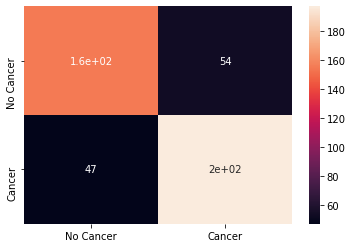

In [29]:
import seaborn as ss
from sklearn.metrics import confusion_matrix

xAxisLabels = ['No Cancer', 'Cancer']
yAxisLabels = ['No Cancer', 'Cancer']

confusionMatrix = confusion_matrix(test_labels, predicted_labels)
ss.heatmap(confusionMatrix, annot = True, xticklabels=xAxisLabels, yticklabels=yAxisLabels)

In [31]:
identificationCorrect = confusionMatrix[0,0] + confusionMatrix[1,1]
identificationIncorrect = confusionMatrix[0,1] + confusionMatrix[1,0]
Identification = identificationCorrect + identificationIncorrect

print('Correct : ', identificationCorrect)
print('Incorrect : ', identificationIncorrect)

Correct :  352
Incorrect :  101
